OSE Scientific Computing | Winter 2021, M.Sc. in Economics, University of Bonn | [Sona Verdiyeva](https://github.com/s6soverd) and [Abraham Raju](https://github.com/Abraham-newbie)

# Prediction of Crime Rates using Brightness derived from Nighttime Satellite Light Images - VIIRS

This notebook contains derivation of brightness index from [VIIRS Nighttime Satellite Light Images](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG), and with the addition of other control variables, the prediction of crime rates in the city of Portland, Oregano state in US. As far as the brightness index concerns, the index is derived for all the neighborhoods in the city of Portland, for which the crime rate datasets are available.

### Table of Contents 
* [1.Overview](#overview) 
* [2.VIIRS - Nighttime Satellite Light Images](#viirs) 
* [3.On the derivation of Brightness Index](#derivation) 
    * [3.1. Accesing the Docstrings](#docstrings)
    * [3.2. Example: Manual Derivation](#manuald)
    * [3.3. Unit Test on Brightness Index function](#unittest)
* [4. Preparation of the data for further analysis](#datawrangling)
* [5. Interactive Mapping: Crime Data and Brightness Values across Years](#mapping)
* [6. Random Forest Classifer: Prediction of crime rate (when classified) using Brightness Index](#rfc)
* [7.Conclusion](#conclusion)
* [8.References](#references)






## 1. Overview <a class="anchor" id="overview"></a>



## 2. VIIRS - Nighttime Satellite Light Images <a class="anchor" id="viirs"></a>

The first digital archive of nighttime lights taken by satellites established at the National Geophysical Data Center in 1992 contains nighttime data from two satelitte platforms - United States Air Force series of polar-orbiting Defense Meteorological Satellite Program-Operational Linescan System (DMSP-OLS) and the current NASA/NOAA SNPP satellite’s the Visible Infrared Imaging Radiometer Suite (VIIRS-DNB) (Xi Chen et al., 2019).  <br>
The first low-light imagery from DMSP dates back to 1960's, while the dataset availability for VIIRS-DNB covers the period from 2014-01-01 onwards. Some new features of VIIRS lights data have eliminated or reduced the limitations of DMSP-OLS sensor. In a nutshell, the main limitations of DMSP-OLS sensor are the following (Feng-Chi Hsu et al., 2015):
* Low radiometric resolution
* No on-board calibration
* Large spatial resolution
* Saturation in urban cores <br>

To process the satellite imagery, we will be using **Google Earth Engine (GEE)**, which is a cloud-based platform for planetary-scale geospatial analysis. It is open and free to the public. In addition, GEE provides access to multiple remotel-sensed datasets, including VIIRS-DNB. To pull VIIRS-DNB nighttime light images from GEE, the eath engine snippet [ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")](https://developers.google.com/earth-engine/datasets/catalog/NOAA_VIIRS_DNB_MONTHLY_V1_VCMSLCFG) is used. <br>
For interactive mapping with GEE, **geemap** -a python package - is used, as it is not part of the standard Python library, it should be seperately downloaded and installed. Geemap can be used to analyse and visualize datasets available in GEE. <br>
To work with satellite data that covers enormous area geospatially, one can work with smaller Area of Interest, that can be either a buffer zone around a latitude-longitude point or a geometry from geopolitical boundary; and then the entire image dataset is clipped into this smaller AOI. <br>
If one wants to focus on the geopolitical boundary of a country, then a **shapefile** of the country is used. Shapefile  is a digital vector storage format for storing the geographic location. Geographic features in a shapefile can be represented by points, lines, or polygons (areas).  <br>
To import shapefile with geemap, the **Coordinate Reference System (CRS)** of the shapefile should be EPSG:4326. CRS basically tells Python how the coordinates inside a shapefile relates to places on Earth. 



## 3.On the derivation of Brightness Index <a class="anchor" id="derivation"></a>

The function below is generic enough to work with VIIRS-DNB image collection for any time period available and for any AOI (either buffer zone or shapefile). The daily images in VIIRS-DNB are aggregated into **monthly composites**, so given a point on Earth and a year, there are only 12 images in the collection. 

In [66]:
#### All the neccessary Python packages
# Import numpy and pandas, geopandas, matplotlib.pyplot
import numpy as np
import pandas as pd
import geopandas
import fiona
import matplotlib.pyplot as plt
# Leaflet map
# ! pip install mplleaflet
import mplleaflet

# Folium for interactive geospatial maps
import folium 

# Functions
import brightness as br
import data_wrangling as dw

# Import os -module that is useful for parsing filepaths
import os

# Convert the dataframe to GeodDataframe
from geopandas import GeoDataFrame

### Import geemap, and ee:
import geemap, ee
### Initialize ee
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()
# Pip install openpyxl for excel sheets
# ! pip install openpyxl

In [2]:
def brightness(date_from, date_to, buffer_df, buffer_dist, band = "avg_rad", aoi_type = "buffer-zone", 
               crs = "EPSG:4326", pathtomyshapefile = None, shp_column_name = None):
    """ Derives Average Monthly Radiance Index for the given AOI and for the given date/period
    
    Args:
        date_from        (ISO date format): YYYY-MM-DD (e.g. 2015-01-01)
        date_to          (ISO date format): YYYY-MM-DD (e.g. 2015-01-31) 
                                * Since VIIRS image collection comprises monthly composites,
                                to derive brightness index for a month, e.g. December 2016, one needs to write it as:
                                date_from = 2016-12-01, date_to = 2016-12-31
                                This will give us one value for Brightness index for a given point on Earth.
                                * To derive the Average Monthly Radiance Index for a given AOI across multiple years, e.g., 
                                from 2014 January till 2021 Mai, the following should be set as the appropriate date:
                                date_from = 2014-01-01, date_to = 2021-05-31
        buffer_df          (dataframe):  * If aoi_type = "shapefile", then buffer_df = None, as we will be supplying
                                        pathtomyshapefile. 
                                        * If aoi_type = "buffer-zone", then buffer_df takes in a dataframe, with three columns:
                                        - "Latitude"
                                        - "Longitute"
                                        - "AOI_Names"
                                        Note:
                                        Names of AOI (in "AOI_Names") should be DISTINCT.
                                        Latitude and Longitude points should be in decimal degrees.
                                        There should be no missing values (If there is, they should be dropped
                                        before feeding it into this function)
        buffer_dist         (integer):  The distance value by which we want to take the buffer zone around the lat/lon point
                                        Ex: 50 km buffer zone around a point should be written as buffer_df = 50000.
                                        If shapefile is used, buffer_dist = None
                     
        band             (str.):      Default is "avg_rad", which stands for Average DNB radiance values
                                and the other option to use is "cf_cvg", which means Cloud-free coverages, This band 
                                can be used to identify areas with low numbers of observations where the quality is reduced.
        aoi_type          (str.):     Default is "buffer_zone", and the other option is "shapefile". 
                                * "buffer-zone" means that the dataset that is supplied in buffer_df is a dataframe
                                with latitude, longitude points corresponding to different AOI on Earth. 
                                Visually, this dataframe has three columns, one corresponding to names of Areas of Interest,
                                the other two being Latitude and Longitude points. Names of AOI should be DISTINCT.
                                Latitude and Longitude points should be in decimal degrees. 
                                * "shapefile" means that the dataset that is supplied in pathtomyshapefile 
                                is a shapefile of all the Areas of Interest.
        crs                (str.):     Default is "EPSG:4326", which is also the only accepted CRS format by geemap. 
                                 If the supplied crs is different from "EPSG:4326", then it will be converted to "EPSG:4326".
        pathtomyshapefile  (a directory path): Default is None. To import the shapefile with geemap, a path to your shapefile 
                                 should be given. The directory where your .shp (shapefile) is located should also include 
                                 .dbf, .cpg, .prj, .shx extension files that comes with a usual shapefile folder. 
        shp_column_name    (str.):     Name of the column in the dataframe inside **pathtomyshapefile
                                  where Areas of Interest; e.g., cities, markets, neighborhoods, 
                                  places, countries etc., are located. 
                                  * Except spaces/dot/comma/slashes there should be no other character 
                                  supplied inbetween the names of places in this column
                                  Example: The name of a place written as Northwest@Aaron should be avoided.
                                  The name of a place written as 'Northwest Industrial' 
                                  or 'Northwest Industrial/Northwest Neighborhood' is allowed
                                  Note: if aoi_type = "buffer-zone", then shp_column_name = None
                   
        
                                
      Returns:
          brightness_index           (dataframe): Average Monthly Radiance Index
          shapefile_dataframe_format (.csv file): Convert the CRS of a shapefile to "EPSG:4326", if it is not 
                                                  in that Reference system, and saves the shapefile for a future reference 
                                                  as a csv file in the directory where this jupyter notebook is located.
          ./AOI_DataSets/Shapefiles  (directory): is a directory that is generated using brightness() function, where 
                                                  each area/place in the one common shapefile inside pathtomyshapefile
                                                  is exported to this directory as seperate shapefiles. 
                                                  
          
  
    """
    
    
    # Selecting the Image collection for the all years, for which VIIRS dataset is available: 2014-01-01 - 2021-05-01
    # NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG is simply the complete dataset
    # For the Dataset - VIIRS Stray-light Corrected Day/Night Band composites -  there are two bands available: 
    # avg_rad(=Average DNB radiance values.) 
    # cf_cvg (=Cloud-free coverages, This band can be used to identify areas with low numbers of observations 
    # where the quality is reduced.) 

    viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate(date_from, date_to).select(band)
    
    if aoi_type == "buffer-zone":
        if len(buffer_df["AOI_Names"].unique()) != len(buffer_df):
            raise ValueError("The names of the places in AOI_Names column are not distinct. "
                            "The number of distinct place names and the length of the dataframe does not match.")
 
    
    if aoi_type == "shapefile":
        
        aoi_shp = pathtomyshapefile
        data = geopandas.read_file(aoi_shp)
        data.to_csv("shapefile_dataframe_format.csv")
        
        
        if crs != "EPSG:4326":
            # Change the CRS of our shapefile to EPSG:4326
            data = data.to_crs(epsg=4326)
            
        # Import the shapefile with geemap
        aois = geemap.shp_to_ee(aoi_shp)
        
        ### Export each area/place into seperate shapefiles
        
         # 1. Group the data by column where AOI is filled in (inside the shapefile dataframe, in pathtomyshapefile)
        grouped = data.groupby(shp_column_name)
        # 2. Import os -module that is useful for parsing filepaths
        # 3. Determine output directory
        output_directory = "AOI_DataSets"
        # 4. Create a new folder called 'Shapefiles'
        sub_folder = os.path.join(output_directory, 'Shapefiles')
        # 5. Check if the folder exists already
        if not os.path.exists(sub_folder):
            # 6. If it does not exist, create one
            os.makedirs(sub_folder)
        # 7. Iterate over the groups
        for key, values in grouped:
            # 8. Format the filename (replace spaces/comma/slashes with underscores,
            # dot with "" using 'replace()' -function)
            output_name = "%s.shp" % key.replace(" ", "_").replace("/", "_").replace(".", "").replace(",", "_")

            # Print some information for the user
            # print("Processing: %s" % key)

            # 9. Create an output path
            outpath = os.path.join(sub_folder, output_name)

            # 10. Export the data
            values.to_file(outpath)
        
        # Collecting all the shapefiles in a list
        DIR = "./AOI_DataSets/Shapefiles"
        areas_list = []
        for subdir in os.listdir(DIR):
            if subdir.endswith(r"shp"):
                areas_list.append(os.path.join(DIR, subdir))
    
    # First we need to create a list of feautures in the form of 
    #[ee.Feature(ee.Geometry.Point(latitude, longitude).buffer(km)),..] or
    #[ee.Feature(imported_shapefile.geometry(), ..]
    #for all the areas of interest. 
    # Specifically, a Feature is an object with a geometry property storing a Geometry object (or null)
    # and a properties property storing a dictionary of other properties.
    
        features = []
        for i in areas_list:
            area = geemap.shp_to_ee(i)
            features.append(ee.Feature(area.geometry(),
                                      {'name': i.split("Shapefiles\\", 1)[1][:-4]}))
        # Areas Names
        areas_names = []
        for i in areas_list:
            name = i.split("Shapefiles\\", 1)[1][:-4]
            areas_names.append(name)
    elif aoi_type == "buffer-zone":
        
        features = []
        for i in range(0, len(buffer_df)):
            features.append(ee.Feature(ee.Geometry.Point([buffer_df.loc[i,"Longitude"],
                                                          buffer_df.loc[i, "Latitude"]]).buffer(buffer_dist),
                                                          {'name': buffer_df["AOI_Names"][i]}))

        
        
    # Given the list of features, we are going to create a Feature Collection for our areas of interest
    aoi_fc = ee.FeatureCollection(features)
    # function to reduce our collection of geometries
    def get_city_avg_rad(img):
        return img.reduceRegions(reducer=ee.Reducer.mean(), collection=aoi_fc, scale=500)

    # function to get individual img dates
    def get_date(img):
        return img.set('date', img.date().format())

    # map these functions to our image collection
    reduced_cities = viirs.map(get_city_avg_rad).flatten()
    dates = viirs.map(get_date)

    # get lists
    key_cols = ['name','mean']
    cities_list = reduced_cities.reduceColumns(ee.Reducer.toList(len(key_cols)), key_cols).values()
    dates_list = dates.reduceColumns(ee.Reducer.toList(1), ['date']).values()

    # some numpy maneuvers to structure our data
    if np.asarray(cities_list.getInfo()).squeeze().shape == (2,):
        df = pd.DataFrame(np.asarray(cities_list.getInfo()).squeeze()).T
        df.columns = key_cols
    else:
        df = pd.DataFrame(np.asarray(cities_list.getInfo()).squeeze(), columns = key_cols)
    dates = np.asarray(dates_list.getInfo()).squeeze()

    
    if aoi_type == "shapefile":
        for c in areas_names:
            df.loc[df['name']==c,'dates'] = dates
    elif aoi_type == "buffer-zone":
        for c in buffer_df["AOI_Names"]:
            df.loc[df['name']==c,'dates'] = dates

    # as we've done before, convert date and set index
    df['dates'] = pd.to_datetime(df['dates'])
    df.set_index('dates', inplace=True)

    # we'll also convert our mean datatype to float
    df['mean'] = df['mean'].astype(float)
    df.columns = ["Names of Places", "Average Radiance Per Pixel Per month"]
    df.reset_index(inplace = True)
    
    return df
    





### 3.1. Docstrings <a class="anchor" id="docstrings"></a>



On how to use the *brightness* function (or any other function) and explanation on the arguments used, one can use the function below to access the **docstrings**:
```Python
    def explanation(function):
        return print(function.__doc__)
```

In [3]:
def explanation(function):
    return print(function.__doc__)


#explanation(function = brightness)

### 3.2. Example: Manual Derivation <a class="anchor" id="manuald"></a>

Let's do a simple derivation of brightness index for a latitude and longitude point of Ganja, a city in the northwest of Azerbaijan, for the date of 2020 October.

In [4]:
# Select the whole VIIRS Day/Night Imagery Collection for the date 2020 October
viirs2020_10 = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG").filterDate("2020-10-01",
                                                                                   "2020-10-31").select('avg_rad').median()
# Create a Google Earth Engine Geometry object with a buffer zone of 50 km around it
lat = 40.6879
lon = 46.3723
aoi_ganja = ee.Geometry.Point([lon, lat]).buffer(50000);

# Clip VIIRS Image that we chose for 2020, October to our Area of Interest
viirs2020_10_clipped = viirs2020_10.clip(aoi_ganja)

# Use ReduceRegeion function to get the mean avg radiance (per month) for the pixels in Ganja
mean_ganja = viirs2020_10_clipped.reduceRegion(reducer=ee.Reducer.mean(), scale = 500)

# Cast these to  ee Numbers and get the number of the computed object
mean_ganja = ee.Number(mean_ganja.get('avg_rad')).getInfo()
mean_ganja

0.6954635802568335

### 3.3. Unit Test on Brightness Index function <a class="anchor" id="unittest"></a>

A **Unit Test** is a small test that checks at a time whether a single component in an application/function/etc. works in the expected way. There are many test runners in Python, the one that is built into standard Python library is called **unittest**, which you need to simply import, for it to run the test. To write and execute your test in unittest, there are some requirements:
* ```Python
import unittest
```
* Put your tests into classes as methods, for that one needs to create a subclass, that inherits from unittest TestCase class
* Add *self* as the first and only argument for test functions
* Instead of built-in assert statement, use self.assertEqual(), self.assertIs(), self.assertTrue(), self.assertIn(),etc. methods of the TestCase Class. 
* To run the test in shell, there are different command line entries; e.g., <br>

This one executes your test file:
```Python
python <'the name of the test file goes here'> 
```

This one executes your test file and -v (verbose) option lists the names of the functions and the result of each:
```Python
python -m unittest -v <'the name of the test file goes here'>
```  

In [5]:
! python -m unittest -v test_brightness

test_brightness_index_for_buffer_zone (test_brightness.TestBrightnessIndexValue)
Test that even one row of lat/lon point produces the expected answer ... ok
test_distinct_area_names (test_brightness.TestBrightnessIndexValue)
Test that the names of the places are distinct ... ok

----------------------------------------------------------------------
Ran 2 tests in 4.099s

OK


## 4. Preparation of the data for further analysis <a class="anchor" id="datawrangling"></a>

In [6]:
path_to_my_shapefile = r"C:\Users\Lenovo\Desktop\OSE_Scientific_Computing_2021\Shapefile_Portland\Neighborhood_Boundaries.shp"
# Identify the crs of the shapefile
crs_portland_shp = br.identify_crs(pathtomyshapefile = path_to_my_shapefile)
# Get the brightness index
brightness_index = br.brightness(date_from = "2015-07-01", date_to = "2021-05-31", 
                              buffer_df = None, buffer_dist = None, band = "avg_rad", aoi_type = "shapefile", 
                              crs = crs_portland_shp.upper(), pathtomyshapefile = path_to_my_shapefile,
                              shp_column_name = "NAME")

In [7]:
# Crime Data for the years 2015 - 2021
df_matched1 = pd.read_csv("Crime_Data\CrimeData-2021.csv")
df_matched2 = pd.read_csv("Crime_Data\CrimeData-2020.csv")
df_matched3 = pd.read_csv("Crime_Data\CrimeData-2019.csv")
df_matched4 = pd.read_csv("Crime_Data\CrimeData-2018.csv")
df_matched5 = pd.read_csv("Crime_Data\CrimeData-2017.csv")
df_matched6 = pd.read_csv("Crime_Data\CrimeData-2016.csv")
df_matched7 = pd.read_csv("Crime_Data\CrimeData-2015.csv")

# Concat them all
dataframes = [df_matched1, df_matched2, df_matched3, df_matched4, df_matched5, df_matched6, df_matched7]
df_concatted = dw.drop_nan_and_uncommon_and_concat(dataframes = dataframes)

# Match and merge with brightness_index - for the Offenses that occurred in the night/ daytime/or both
df_matched = dw.matching_names(df1 = df_concatted, 
                               df2 = brightness_index, 
                               c1 = "Neighborhood", 
                               c2 = "Names of Places")
df_merged = dw.merge(df_index = brightness_index, df_matched = df_matched, type = "night")
df_with_controls = dw.add_controls(df_merged = df_merged)

# Saving also the crime data with controls for daytime and for all daylong occurence
df_merged_day = dw.merge(df_index = brightness_index, df_matched = df_matched, type = "day")
df_with_controls_day = dw.add_controls(df_merged = df_merged_day)

df_merged_all = dw.merge(df_index = brightness_index, df_matched = df_matched, type = "all")
df_with_controls_all = dw.add_controls(df_merged = df_merged_all)


df_with_controls_day.to_csv("df_with_controls_daytime.csv")
df_with_controls_all.to_csv("df_with_controls_alldaylong.csv")
df_with_controls.to_csv("df_with_controls_nighttime.csv")

## 5. Interactive Mapping: Crime Data and Brightness Values across Years <a class="anchor" id="mapping"></a>

In [8]:
# Data Loading - shapefile of Neighborhoods in Portland in .csv format
shapefile_portland = pd.read_csv("shapefile_dataframe_format.csv")

# in .shp format
data = geopandas.read_file(path_to_my_shapefile)
data = data.to_crs(epsg=4326)

### Exploratory Data Analysis

**1.** Bar Chart to visualize the population data of Portland by neighborhood.

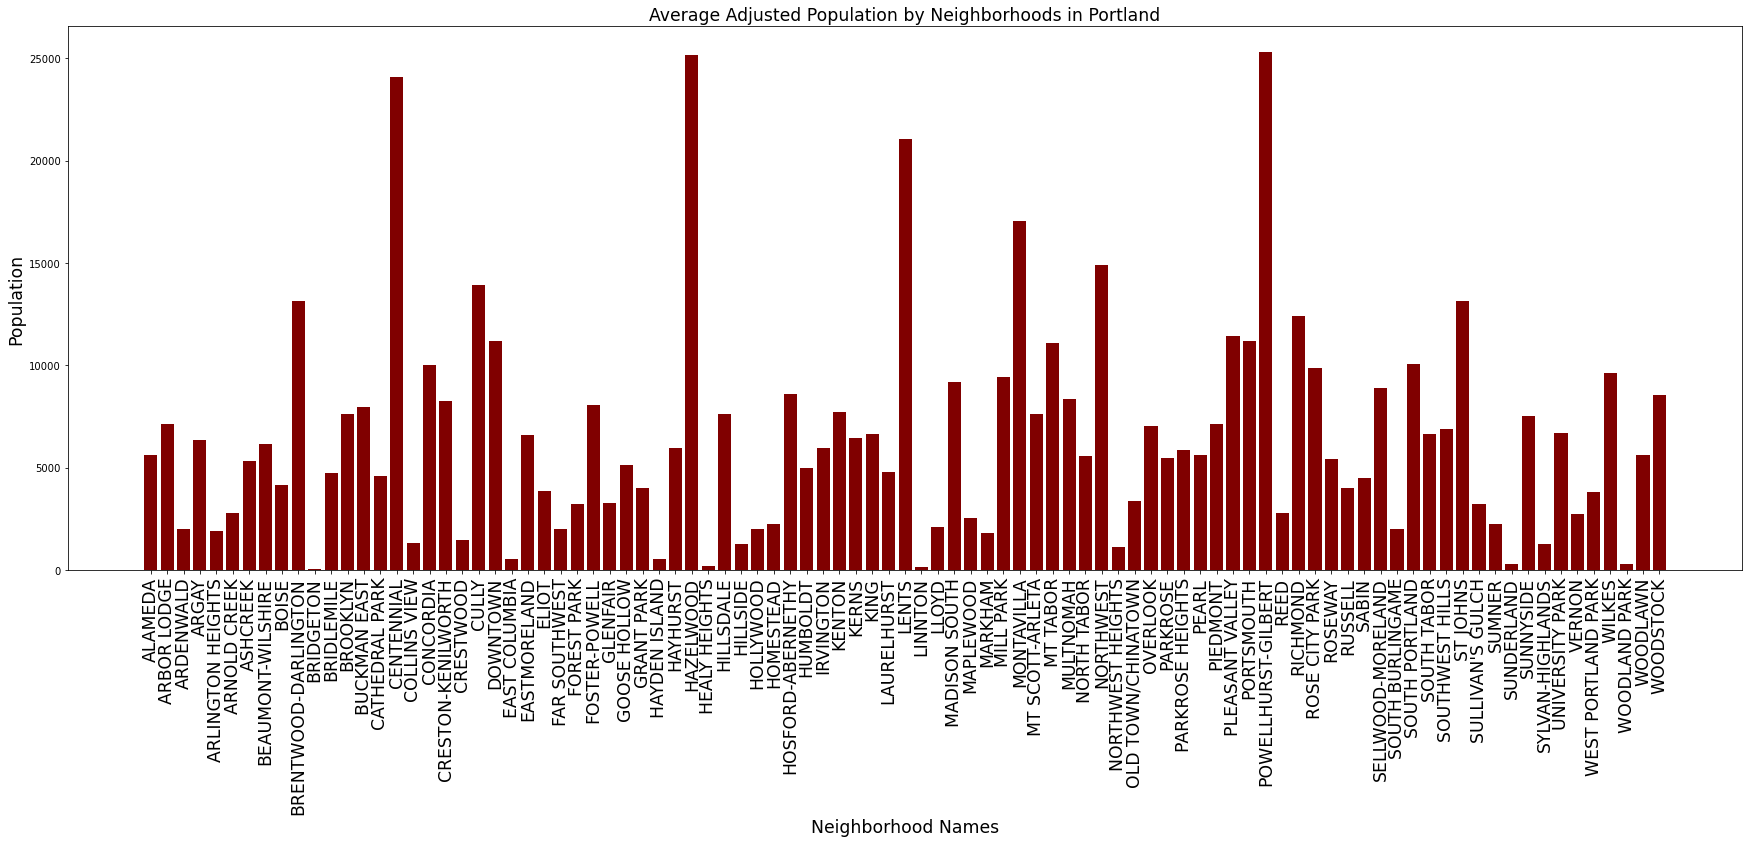

In [9]:
# Create a new column - Year
df_with_controls["Year"] = df_with_controls.OccurMonth_Year.astype(str).str[:-3]
# Group by the dataset by Neighborhood and Year, and average the population for the years 2015 to 2021 by Neighborhood
average_adj_pop_by_neighborhood = df_with_controls.groupby(["Neighborhood", "Year"])["adj_popn"].mean().reset_index()

# Create the figure
fig = plt.figure(figsize = (30, 10))
x = average_adj_pop_by_neighborhood[average_adj_pop_by_neighborhood["Year"] == "2015"]["Neighborhood"]
y = average_adj_pop_by_neighborhood[average_adj_pop_by_neighborhood["Year"] == "2015"]["adj_popn"]
 
# creating the bar plot
plt.bar(x, y, color ='maroon')
 
plt.xlabel("Neighborhood Names", fontsize = "xx-large")
plt.ylabel("Population", fontsize = "xx-large")
plt.title("Average Adjusted Population by Neighborhoods in Portland", fontsize = "xx-large")
plt.xticks(rotation = 90, fontsize = "xx-large")
plt.show()

**2.** Displaying the geopolitical boundaries of Portland.

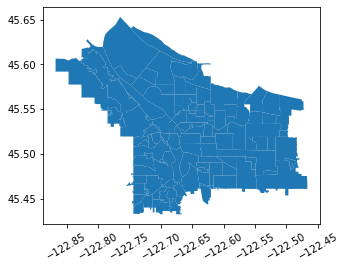

In [10]:
data.plot()
plt.xticks(rotation = 30)
plt.show()

###  Choropleth Map using Shapefile

In [70]:
# Converting pandas.DataFrame to GeoDataFrame object and
# Converting pandas.Series to GeoSeries object
# Converting 'geomettry' column from being Series to GeoSeries so that the info inside is considered to be geospatial

def df_to_geo_df(df):
    df = GeoDataFrame(df)
    # Converting Series Object to GeoSeries
    df['geometry'] = geopandas.GeoSeries.from_wkt(df['geometry'])
    geo_df = geopandas.GeoDataFrame(df, geometry='geometry')
    
    return geo_df

#### 1. By Population

In [68]:
# Bringing the names of places in shapefile to the form that is used in crime dataset
list_names = []
for name in shapefile_portland["NAME"]:
    n = name.replace(" ", "_").replace("/", "_").replace(".", "").replace(",", "_")
    list_names.append(n)

# Creating a column to include the updated Names
shapefile_portland["Matched_Names"] = list_names

# Slicing the shapefile_portland dataframe to only include the Names and Geometry of the areas
sliced_shapefile = shapefile_portland[["Matched_Names", "geometry"]].dropna()

In [71]:
# Merge Shapefile of Neighborhoods with crime dataset - Year 2015 is provided, but the population is same across years
# as the controls used are only provided for the same one year, so here the purpose is not which year but rather
# how dense is the population across the communities.
population_2015 = df_with_controls[df_with_controls["Year"] == "2015"].groupby(["Matched_Names",
                                                                                "Year"])["adj_popn"].mean().reset_index()

shp_merged_with_crime_data = pd.merge(
                                        left=population_2015,
                                        right=sliced_shapefile,
                                        on='Matched_Names',
                                        how='left', 
                                         )
shp_merged_with_crime_data = shp_merged_with_crime_data.drop_duplicates(subset = ['Matched_Names', 'Year'],
                                                                        keep = 'last').reset_index(drop = True)
geo_df = df_to_geo_df(df = shp_merged_with_crime_data)
geo_df = geo_df.set_crs('epsg:3857')
# geo_df.crs

In [121]:
# Create the Choropleth Map of Population across Neighborhoods in Portland using Matplotlib
#fig, ax = plt.subplots(figsize=(10,6))
#geo_df.plot(column='adj_popn', cmap='Reds',  linewidth=1, ax=ax, edgecolor='0.9', legend=True)
#ax.axis('off')
#plt.title("Population of Neighborhoods in Portland")
#plt.show()
# Interactive Leaflet Choropleth Map centered at lat-lon of Portland using Folium
geo_map = folium.Map(location=[45.5152, -122.6784], zoom_start=11,tiles=None)
folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(geo_map)

#scale = (geo_df['adj_popn'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()
scale = np.linspace(geo_df['adj_popn'].min(), geo_df['adj_popn'].max(), 6, dtype=int).tolist()
scale[-1] = scale[-1] + 1

geo_map.choropleth(
 geo_data=geo_df,
 name='Choropleth',
 data=geo_df,
 columns=['Matched_Names', 'adj_popn'],
 key_on="feature.properties.Matched_Names",
 fill_color='BuPu',
 bins=scale,
 fill_opacity=1,
 line_opacity=0.2,
 legend_name='Population in Portalnd by Neighborhood (quantile scale)',
 smooth_factor=0
)
geo_map.save(os.path.join('./Figures', 'population_portland_by_neighborhoods.html'))
geo_map

#### 2. By Crime Rate and Year

In [95]:
def choropleth_by_year(merged_df, year = "2015"):
    # Create a new column - Year
    merged_df["Year"] = merged_df.OccurMonth_Year.astype(str).str[:-3]
    # Group by the dataset by Neighborhood and Year, and calculate the crime rate for the years 2015 to 2021 by Neighborhood
    crime_rate_df = merged_df[["Matched_Names",
                              "Year", 
                              "adj_popn",
                              "Total_Offenses"]].groupby(["Matched_Names", "Year", 
                                                        "adj_popn"])["Total_Offenses"].sum().reset_index().eval('Offense_Rate_per_100k = (Total_Offenses / adj_popn) * 100000')
    shp_crime_rate = pd.merge(left=crime_rate_df,
                              right=sliced_shapefile,
                              on='Matched_Names',
                              how='left', 
                            )
    shp_crime_rate = shp_crime_rate.drop_duplicates(subset = ['Matched_Names', 'Year'],
                                                    keep = 'last').reset_index(drop = True)
    
    # Crime Rate by Year
    shp_crime_rate = shp_crime_rate.loc[shp_crime_rate["Year"] == year, :]
    

    # Converting the dataframe to GeodDataframe
    geo_df = df_to_geo_df(df = shp_crime_rate)
    if geo_df.crs is None:
        geo_df = geo_df.set_crs('epsg:3857')
 
    # Interactive Leaflet Choropleth Map centered at lat-lon of Portland using Folium
    geo_map = folium.Map(location=[45.5152, -122.6784], zoom_start=11,tiles=None)
    folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(geo_map)
    

    #scale = (geo_df['adj_popn'].quantile((0,0.1,0.75,0.9,0.98,1))).tolist()
    scale = np.linspace(geo_df['Offense_Rate_per_100k'].min(), geo_df['Offense_Rate_per_100k'].max(), 6, dtype=int).tolist()
    scale[-1] = scale[-1] + 1

    geo_map.choropleth(
     geo_data=geo_df,
     name='Choropleth',
     data=geo_df,
     columns=['Matched_Names', 'Offense_Rate_per_100k'],
     key_on="feature.properties.Matched_Names",
     fill_color='BuPu',
     bins=scale,
     fill_opacity=1,
     line_opacity=0.2,
     legend_name='Total Offenses Rate in Portland by Neighborhood (per 100,000)',
     smooth_factor=0
    )
    geo_map.save(os.path.join('./Figures', 'offense_Rate_per100k_portland_by_neighborhoods.html'))
    
    
    # Create the Choropleth Map of Population across Neighborhoods in Portland
    #fig, ax = plt.subplots(1, figsize=(10,6))
    #geo_df.plot(column='Offense_Rate_per_100k', cmap='Reds',  linewidth=1, ax=ax, edgecolor='0.9', legend=True)
    #ax.axis('off')
    #plt.title(f"Crime Rate per 100000 by Neighborhoods in Portland for the year {year}")
    #plt.show()
    
    
    return geo_map


In [97]:
choropleth_by_year(merged_df = df_with_controls, year = "2021")

#### 3. By Brightness Index and Year

In [102]:
# Generate annual average of brightness index by Neighborhoods in Portland
brightness_index["Year"] = brightness_index.OccurMonth_Year.astype(str).str[:-3]
brightness_annual_ave = brightness_index.groupby(["Names of Places",
                                                  "Year"])["Average Radiance Per Pixel Per month"].mean().reset_index()

In [123]:
def choropleth_by_brightness(df, year = "2015"):
    merged_shp_brightness = sliced_shapefile.merge(df[df["Year"] == year], 
                          left_on = "Matched_Names",
                          right_on = "Names of Places", 
                          how = "left")
    
    # Converting the dataframe to GeodDataframe
    geo_df = df_to_geo_df(df = merged_shp_brightness)
    if geo_df.crs is None:
        geo_df = geo_df.set_crs('epsg:3857')
    
    # Add text to the map to list top 5 and last 5 neighborhoods for the Annual Average of Average Radiance per pixel per month
    df_br = merged_shp_brightness[['Matched_Names', 'Average Radiance Per Pixel Per month']].copy(deep=True)
    df_br.sort_values('Average Radiance Per Pixel Per month', ascending=False, inplace=True)
    df_br.reset_index(drop=True, inplace=True)
    df_br.index += 1

    legend_top = '\n'.join(df_br.head().to_string().split('\n')[1:])
    legend_last = '\n'.join(df_br.tail().to_string().split('\n')[1:])
    legend_html =   '''
                    <div style="position: fixed; 
                                top: 100px; right: 50px; width: 300px; height: 300px; 
                                border:2px solid blue; z-index:9999; font-size:14px;">
                                &nbsp; <br>
                                &nbsp; <br>
                                Ranking: Annual average of Brightness by Neighborhoods in Portland
                                {} 
                                ......  
                                {}
                    </div>
                    '''
    legend_html = legend_html.format(legend_top,legend_last)
    legend_html = legend_html.replace('\n','<br> ')
    
    # Interactive Leaflet Choropleth Map centered at lat-lon of Portland using Folium
    geo_map = folium.Map(location=[45.5152, -122.6784], zoom_start=11,tiles=None)
    folium.TileLayer('CartoDB positron',name="Light Map",control=False).add_to(geo_map)
    geo_map.get_root().html.add_child(folium.Element(legend_html))
    scale = np.linspace(geo_df['Average Radiance Per Pixel Per month'].min(), 
                        geo_df['Average Radiance Per Pixel Per month'].max(), 6, dtype=int).tolist()
    scale[-1] = scale[-1] + 1

    geo_map.choropleth(
     geo_data=geo_df,
     name='Choropleth',
     data=geo_df,
     columns=['Matched_Names', 'Average Radiance Per Pixel Per month'],
     key_on="feature.properties.Matched_Names",
     fill_color='BuPu',
     bins=scale,
     fill_opacity=1,
     line_opacity=0.2,
     legend_name=f'Annual Average of average Radiance in {year}',
     smooth_factor=0
    )
    geo_map.save(os.path.join('./Figures', 'annual_average_brightness_in_portland_by_neighborhoods.html'))
    

    # Create the Choropleth Map of Population across Neighborhoods in Portland
    #fig, ax = plt.subplots(1, figsize=(10, 4))
    #geo_df.plot(column='Average Radiance Per Pixel Per month', cmap='viridis_r', 
                #linewidth=1, ax=ax, edgecolor='0.9', legend=True)
    
    
    #ax.axis('off')
    #plt.title(f"Annual Average of the Average Radiance Per Pixel Per month by Neighborhoods in Portland for the year {year}")
    
    #plt.show()
    
    return geo_map
    

In [125]:
choropleth_by_brightness(df = brightness_annual_ave, year = "2019")